In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

# import bt_mle_utils as mle
# from simulation_utils import *

In [8]:
def get_beta_with_gap(N, delta = 0.1):
    beta = np.arange(N) * delta
    beta = beta - np.mean(beta)
    return beta

def get_er_edge(n, m):
    """
    generate m edges uniformly randomly from a graph with n nodes
    """
    all_edge = np.where(np.triu(np.ones((n,n)), 1))
    ix = np.random.choice(n * (n - 1) // 2, m, replace = True)
    edge = [(all_edge[0][i], all_edge[1][i]) for i in ix]
    return edge

def get_X_from_edge(edge, n):
    m = len(edge)
    X = np.zeros((m, n))
    for i, e in enumerate(edge):
        X[i,e[0]] = 1
        X[i,e[1]] = -1
    return X

def get_X(n, m):
    edge = get_er_edge(n, m)
    return get_X_from_edge(edge, n)


def logistic(X, beta):
    beta = beta.reshape((-1,1))
#     t = np.clip(X @ beta, a_max = 1000, a_min = -1000)
    t = X @ beta
    exp = np.exp(t)
    return exp / (1 + exp)

def loglike_logistic(X, beta, y):
    y = y.reshape((-1,1)) 
    t = X @ beta
    res = y.T @ t - np.sum(np.log(1 + np.exp(t)))
    return res.item()
#     prob = logistic(X, beta)
#     return np.sum(y * np.log(prob + 1e-8) + (1 - y) * np.log(1 - prob + 1e-8))
#     return np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))

def grad_logistic(X, beta, y):
    prob = logistic(X, beta)
    return X.T @ (y.reshape((-1,1)) - prob)

def hessian_logistic(X, beta, y):
    prob = logistic(X, beta).reshape((len(y),))
#     return -(prob * (1 - prob) * X.T) @ X - 1e-8 * np.eye(X.shape[1])
    return -(prob * (1 - prob) * X.T) @ X


def bt_newton_solver(X_train, y_train, lam = 0.1, max_step = 50, tol = 1e-12, verbose = False):
    n, p = X_train.shape
    beta_hat = np.zeros((p,1))
    step_size = 1
    l_path = []
    i = 0
    
    err = 10
    a, b = 0.01, 0.3
    max_back = 100

    obj_old = np.inf
    while i < max_step and err > tol:
        g = -grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat
        H = -hessian_logistic(X_train, beta_hat, y_train) + lam * np.eye(p)
        beta_new = beta_hat + 0
        s = step_size

        v = -np.linalg.solve(H, g)
        for j in range(max_back):
            beta_new = beta_new + s * v
            obj_new = -loglike_logistic(X_train, beta_new, y_train) + lam / 2 * np.sum(beta_new**2)
            if obj_new <= obj_old + b * s * g.T @ v:
                break
            s *= a
#         err = np.sum((beta_new - beta_hat)**2)**0.5
        beta_hat = beta_new
        err = np.sum((-grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat)**2)**0.5
        obj_old = obj_new
        l_path.append(obj_new)
        i += 1
        if verbose:
            print("step: ",i," is done")
    if verbose:
        print('i: ', i)
        print("err: ", err)
        print("beta_hat: ", beta_hat)
    
    return beta_hat, l_path

def logistic_beta_error(beta, beta_hat):
    beta = beta.squeeze()
    beta_hat = beta_hat.squeeze()    
    return np.sum((beta - beta_hat)**2)**0.5, np.sum(np.abs(beta - beta_hat)**2)**0.5 / np.sum(np.abs(beta)**2)**0.5

def logistic_y_error(beta, beta_hat, n = 10000):
    p = len(beta)
    X_test = np.random.uniform(0,1,(n,p))
    y_test = np.random.binomial(1, logistic(X_test, beta))
    y_hat = (logistic(X_test, beta_hat) > 0.5).astype(int)
    return np.sum(np.abs(y_test - y_hat)) / n

def logistic_prob_error(beta, beta_hat, n = 10000):
    p = len(beta)
    X_test = np.random.uniform(0,1,(n,p))
    prob_test = logistic(X_test, beta)
    prob_hat = logistic(X_test, beta_hat)
    return np.sum(np.abs(prob_test - prob_hat)) / n


In [3]:
a = np.arange(10)
a[2+1:4]

array([3])

In [5]:
a = np.ones((3,10))
a[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [138]:
def cusum_borda(Y, sm, em, smooth = 100):
    """
    Y: T x n array
    """
    y_train_joint = Y[int(sm):int(em) + 1]
    nt, n = y_train_joint.shape
    if nt < 2 * smooth:
        return np.zeros(nt - 1)
    
    borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

    borda_left[0] = y_train_joint[0][:]
    borda_right[-1] = y_train_joint[-1][:]

    rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

    rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
    rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')

    diff = np.zeros(nt - 1)

    for i in range(1, nt):
        borda_left[i] = borda_left[i - 1] + y_train_joint[i]
        borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + y_train_joint[nt - 1 - i]

        rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
        rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

    for i in range(nt - 1):
        # change the metric when needed
        diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1])) / n
    
    
    for i in range(smooth):
        diff[i] = diff[smooth]
        diff[-i-1] = diff[-smooth-1]
    
    return diff
    

def wbs_original(Y, cusum_func, start, end, intervals, threshold, smooth = 100, buffer = 200):
    n_interval = len(intervals)
    cp_loc, cp_val = [], []
    cusum_val = np.zeros(end - start)
    
    def wbs_recurs(Y, start, end, intervals, threshold):
        nonlocal cp_loc, cp_val, cusum_val, n_interval
        cand_loc, cand_val = np.zeros(n_interval), np.ones(n_interval) * -1
        for m in range(n_interval):
            sm, em = int(max(intervals[m][0], start)), int(min(intervals[m][1], end))
#             print(sm)
#             print(em)
            if em - sm > buffer:
                cusum = cusum_func(Y, sm, em, smooth = smooth)
#                 print("len" + str(len(cusum)))
                for t in range(sm, em):
                    cusum_val[t] = cusum[t - sm]
#                 print(np.argmax(cusum))
                cand_loc[m] = sm + 1 + np.argmax(cusum)
                cand_val[m] = cusum_val[int(cand_loc[m])]
        m_star = np.argmax(cand_val)
        if cand_val[m_star] > threshold:
            bm = int(cand_loc[m_star])
            cp_loc.append(int(bm))
            sm, em = int(max(intervals[m_star][0], start)), int(min(intervals[m_star][1], end))
            print("new cp: " + str(bm) + " with cusum " + str(cusum_val[bm]) + " in interval: " + str([sm, em]))
            wbs_recurs(Y, start, bm - buffer, intervals, threshold)
            wbs_recurs(Y, bm + buffer, end, intervals, threshold)
    
    wbs_recurs(Y, start, end, intervals, threshold)
    for loc in cp_loc:
        cp_val.append(cusum_val[loc])
    return cp_loc, cp_val, cusum_val

In [27]:
max(1,2)

2

In [92]:
T = 3
n = 50
m = np.array([10000, 10000, 10000])
cp_truth = np.cumsum(m)[:T-1]

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m[t]) for t in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))
Y = np.zeros_like(X_train_joint)
nt = len(y_train_joint)
for i in range(nt):
    Y[i] = X_train_joint[i] * (2 * y_train_joint[i] - 1)

[6.76494854 7.28171091]


In [36]:
cp_truth[0]

10000

In [61]:
intervals

[[5000, 15000], [15000, 25000]]

In [97]:
start, end = 0, len(Y)
intervals = []
delta = m // 2
for i in range(T - 1):
    intervals.append([cp_truth[i] - delta[i], cp_truth[i] + delta[i]])

threshold = 15
    
cp_loc, cp_val, cusum_val = wbs_original(Y, cusum_borda, start, end, intervals, threshold)

0
9999
0
9999
9995
9999


In [98]:
cp_loc

[5001, 5003]

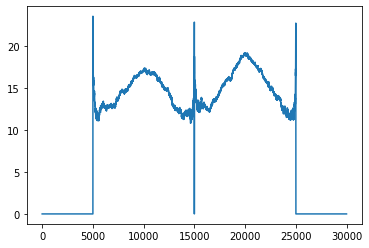

In [99]:
plt.plot(cusum_val, '-')

In [103]:
Y.shape

(30000, 50)

In [140]:
start, end = 0, len(Y)
intervals = [[start, end - 1]]

threshold = 15
    
cp_loc, cp_val, cusum_val = wbs_original(Y, cusum_borda, start, end - 1, intervals, threshold, smooth = 100, buffer = 200)

new cp: 20076 with cusum 20.18 in interval: [0, 29999]
new cp: 9958 with cusum 16.88 in interval: [0, 19876]


In [126]:
cp_loc

[20076, 19976, 9980]

In [145]:
min(cusum_val)

3.12

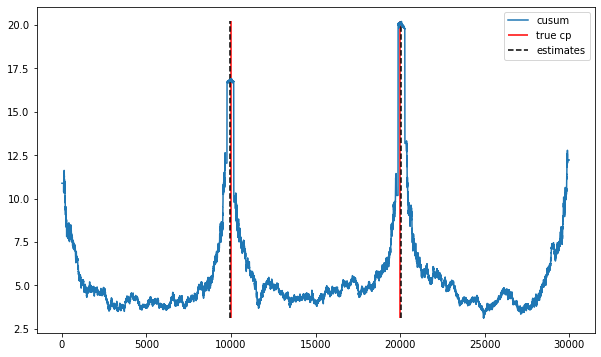

In [158]:
plt.figure(figsize = (10, 6))
plt.plot(cusum_val, '-')
plt.vlines(cp_truth, color = 'red', label = "true cp", ymin = min(cusum_val), ymax = max(cusum_val))
plt.vlines(cp_loc, color = 'black', linestyles = "dashed", label = "estimates", ymin = min(cusum_val), ymax = max(cusum_val))
plt.legend(["cusum", "true cp", "estimates"])
plt.savefig('wbs_borda_2cp.pdf')

In [65]:
n = 50

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

m = 10000

X_train = get_X(n, m)
y_train = np.random.binomial(1, logistic(X_train, beta))

beta_hat, l_path = bt_newton_solver(X_train, y_train)

print(logistic_beta_error(beta, beta_hat))
print(logistic_y_error(beta, beta_hat))
print(logistic_prob_error(beta, beta_hat))

(0.6454748927051998, 0.14106636597832084)
0.2892
0.027506678587686663


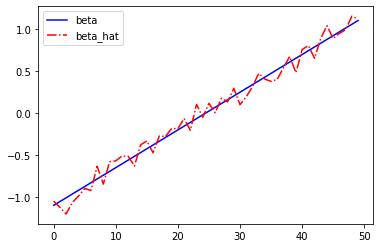

In [66]:
plt.plot(beta, 'b-')
plt.plot(beta_hat, 'r-.')
plt.legend(['beta','beta_hat'])

In [53]:
l_path

[-5870.348435704885,
 -5853.039842428691,
 -5852.991035908558,
 -5852.991035414691,
 -5852.991035414691,
 -5852.9910354146905,
 -5852.991035414692]

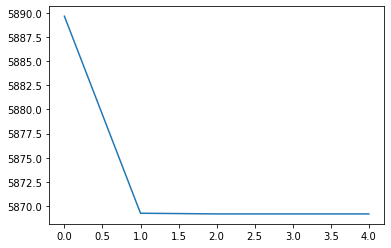

In [64]:
plt.plot(l_path)

(array([ 378.,  575.,  891.,  970.,  886., 1092., 1117., 1046., 1447.,
        1598.]),
 array([0.1       , 0.13887915, 0.17775831, 0.21663746, 0.25551662,
        0.29439577, 0.33327493, 0.37215408, 0.41103324, 0.44991239,
        0.48879155]),
 <a list of 10 Patch objects>)

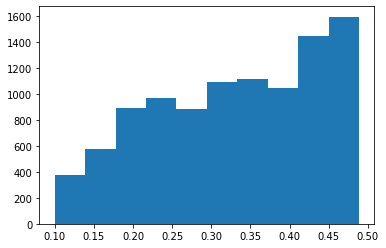

In [67]:
plt.hist(logistic(X_train, beta))

## Try Borda count

In [104]:
def borda_count(X, y):
    """
    borda count of n items
    X: m x n array
    y: m x . array
    """
    y = y.squeeze()
    res = np.sum(X.T * (2 * y - 1), axis = 1).squeeze()
    return res

def ranking_error(v,v_hat,normalize = True):
    r = stats.rankdata(v, method = 'min')
    r_hat = stats.rankdata(v_hat, method = 'min')
    n = len(v)
    if normalize:
        res = np.sum(np.abs(r - r_hat)) / (n**2 // 4)
    else:
        res = np.sum(np.abs(r - r_hat))
    return res

In [108]:
n = 50

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

m = 10000

X_train = get_X(n, m)
y_train = np.random.binomial(1, logistic(X_train, beta))

In [109]:
borda = borda_count(X_train ,y_train)

In [110]:
ranking_error(beta, borda)

0.1488

Check the distribution of CUSUM-borda

In [ ]:
def one_trial_cusum_borda():
    T = 2
    n = 50
    m = 10000

    beta = np.zeros((T, n))

    t = 0.9
    kappa = np.log(t / (1 - t))
    delta = 1
    beta_t = get_beta_with_gap(n, delta)
    beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
    beta[0] = beta_t[:]
    beta[1] = beta_t[np.random.permutation(n)]

    diff = np.zeros(T - 1)
    for t in range(1, T):
        diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
    print(diff)

    # X_train = np.random.normal(0,1,(n,p))
    X_train = np.stack([get_X(n, m) for _ in range(T)])
    y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

    X_train_joint = X_train.reshape((-1, n))
    y_train_joint = y_train.reshape((-1, 1))

    nt = len(y_train_joint)
    borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

    borda_left[0] = X_train_joint[0][:]
    borda_right[-1] = X_train_joint[-1][:]

    rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

    rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
    rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


    smooth = 200

    diff = np.zeros(nt - 1)

    for i in range(1, nt):
        borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
        borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)

        rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
        rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

    for i in range(nt - 1):
        diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1])) / n
    
    for i in range(smooth):
        diff[i] = diff[smooth]
        diff[-i-1] = diff[-smooth-1]    

In [73]:
a = np.array([1,2,3,4])
ix = np.random.permutation(4)
b = a[ix]
a[0] = 10
b

array([3, 1, 2, 4])

Single change point

In [120]:
T = 2
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.70553895]


In [89]:
nt = len(y_train_joint)
borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

borda_left[0] = X_train_joint[0][:]
borda_right[-1] = X_train_joint[-1][:]

rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


buffer = 1000

diff = np.zeros(nt - 1)

for i in range(1, nt):
    borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
    borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)
    
    rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
    rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

for i in range(nt - 1):
    diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1]))

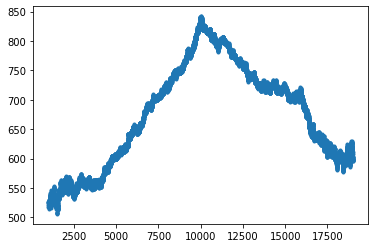

In [90]:
plt.plot(np.arange(buffer, nt - buffer), diff[buffer:nt - buffer], '.')

In [124]:
T = 2
n = 50
m = 100000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.12703734]


In [125]:
borda_joint = borda_count(X_train_joint, y_train_joint)
beta_joint = beta.mean(axis = 0)
ranking_error(beta_joint, borda_joint)

0.0784

Two change points

In [85]:
T = 3
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.73874156 6.5274544 ]


In [86]:
nt = len(y_train_joint)
borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

borda_left[0] = X_train_joint[0][:]
borda_right[-1] = X_train_joint[-1][:]

rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


buffer = 1000

diff = np.zeros(nt - 1)

for i in range(1, nt):
    borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
    borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)
    
    rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
    rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

for i in range(nt - 1):
    diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1])) / n

In [90]:
diff[:30]

array([24.34, 23.74, 23.12, 21.78, 20.58, 20.64, 20.82, 20.58, 20.8 ,
       20.8 , 20.38, 20.5 , 20.5 , 20.22, 19.2 , 19.06, 18.3 , 18.48,
       17.96, 17.22, 17.9 , 17.72, 17.68, 17.38, 16.86, 16.94, 16.72,
       16.12, 16.48, 16.36])

In [87]:
len(diff[buffer:nt - buffer])

28000

In [71]:
np.arange(1,5)

array([1, 2, 3, 4])

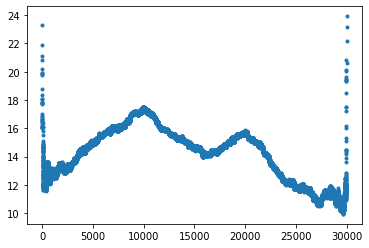

In [73]:
buffer = 0
plt.plot(np.arange(buffer, nt - 1 - buffer), diff[buffer:nt - 1 - buffer], '.')

More change points

In [117]:
T = 4
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.52868646 6.16955266 4.57568243]


In [118]:
nt = len(y_train_joint)
borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

borda_left[0] = X_train_joint[0][:]
borda_right[-1] = X_train_joint[-1][:]

rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


buffer = 1000

diff = np.zeros(nt - 1)

for i in range(1, nt):
    borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
    borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)
    
    rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
    rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

for i in range(nt - 1):
    diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1]))

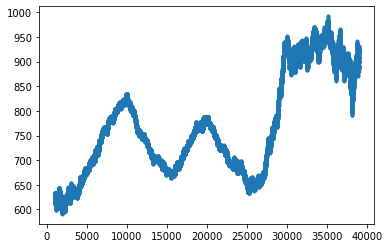

In [119]:
plt.plot(np.arange(buffer, nt - buffer), diff[buffer:nt - buffer], '.')